In [61]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 
import math 
from datetime import datetime
print("Setup Complete")
%matplotlib inline
import os


Setup Complete


In [147]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [148]:
users = pd.read_csv('data/users.csv')
hotels = pd.read_csv('data/hotels.csv')
flights = pd.read_csv('data/flights.csv')

In [149]:
users.columns

Index(['code', 'company', 'name', 'gender', 'age'], dtype='object')

In [150]:
users.isnull().sum()


code       0
company    0
name       0
gender     0
age        0
dtype: int64

In [151]:
users.head()


,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44


In [152]:
users.groupby("company").size()


company
4You             453
Acme Factory     261
Monsters CYA     195
Umbrella LTDA    194
Wonka Company    237
dtype: int64

In [153]:
users.groupby("gender").size()


gender
female    448
male      452
none      440
dtype: int64

In [154]:
users.groupby("age").size()


age
21    31
22    30
23    27
24    27
25    26
26    26
27    31
28    34
29    29
30    27
31    33
32    44
33    34
34    29
35    27
36    39
37    31
38    24
39    32
40    31
41    27
42    33
43    27
44    31
45    23
46    41
47    39
48    24
49    30
50    27
51    29
52    24
53    29
54    22
55    35
56    28
57    31
58    28
59    31
60    24
61    31
62    23
63    27
64    33
65    31
dtype: int64

In [155]:
users['ageRange'] = pd.cut(users.age, [20,30,40,50,60,65])
users.groupby("ageRange").size()

ageRange
(20, 30]    288
(30, 40]    324
(40, 50]    302
(50, 60]    281
(60, 65]    145
dtype: int64

In [156]:
flights.columns

Index(['travelCode', 'userCode', 'from', 'to', 'flightType', 'price', 'time',
       'distance', 'agency', 'date'],
      dtype='object')

In [157]:
flights.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


In [158]:
flights.groupby("agency").size()


agency
CloudFy        116378
FlyingDrops     38758
Rainbow        116752
dtype: int64

In [159]:
flights.groupby(['travelCode', 'userCode']).size().max()


2

In [160]:
flights.groupby(['travelCode', 'userCode']).size().min()


2

In [161]:
flights["datetime"] = pd.to_datetime(flights["date"])
flights['monthYear'] = pd.to_datetime(flights['datetime']).dt.to_period('M')
flights['year'] = pd.to_datetime(flights['datetime']).dt.year
flights['month'] = pd.to_datetime(flights['datetime']).dt.month

In [162]:
print("The dataset ranges from ",flights["datetime"].min(),"to", flights["datetime"].max())


The dataset ranges from  2019-09-26 00:00:00 to 2023-07-24 00:00:00


In [163]:
month_grow_rate = flights.groupby('monthYear')["price"].sum().to_frame()
# Drop 2019-09 fror its data is not completed
month_grow_rate  = month_grow_rate .iloc[1: , :]
# Lag the last price row to the next one 
month_grow_rate['lastMonthPrice'] = month_grow_rate['price'].shift(periods=1)
# Calculate the month growth rate
month_grow_rate['monthGrowthRate'] = (month_grow_rate['price']-month_grow_rate['lastMonthPrice'])/month_grow_rate['lastMonthPrice']
# Roud up the decimal
month_grow_rate['MoM(%)'] = round((month_grow_rate['monthGrowthRate']),3) * 100 
# Reset index in the dataframe
month_grow_rate = month_grow_rate .reset_index()
month_grow_rate['MoM(%)'] = round(round((month_grow_rate['monthGrowthRate']),3) *100,2)
month_grow_rate['monthYearInt'] = month_grow_rate['monthYear'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

[Text(0.5, 0, 'Year/Month'), Text(0, 0.5, 'monthovermonth(%)')]

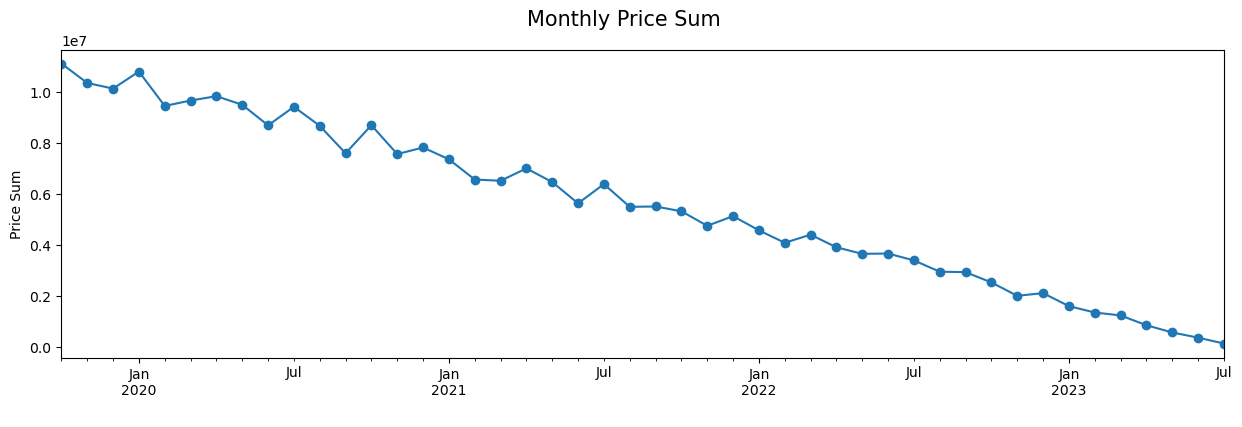

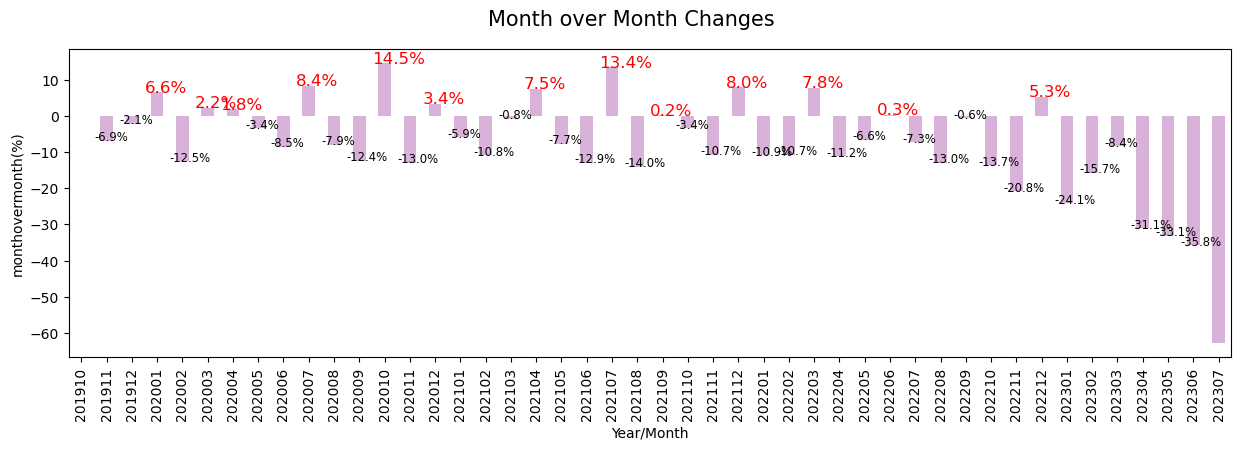

In [164]:
fig1, ax1 = plt.subplots(figsize=(15, 4))
fig2, ax2 = plt.subplots(figsize=(15, 4))
# ax2=axs.twinx()
month_grow_rate.groupby('monthYear')["price"].sum().plot(kind='line', ax=ax1, marker="o")
month_grow_rate.groupby('monthYearInt')["MoM(%)"].sum().plot(
    kind='bar', ax=ax2,color="purple", alpha=0.3, label=True)

for a, b, in zip(range(45),month_grow_rate["MoM(%)"]):
    if b < 0:
        plt.text(a-0.5, b, str(b) + '%', rotation=0, fontsize='small')
    if b > 0:
        plt.text(a-0.5, b, str(b) + '%', rotation=0, fontsize='large', c = 'red')
    
fig1.suptitle('Monthly Price Sum', fontsize = '15')
fig2.suptitle('Month over Month Changes', fontsize = '15')

ax1.set(xlabel=' ', ylabel='Price Sum')
ax2.set(xlabel='Year/Month', ylabel='monthovermonth(%)')

In [165]:
flight_data = flights.loc[(flights['monthYear'] >= '2019-10') & (flights['monthYear'] <= '2021-09')]
data = flight_data.groupby(['year','monthYear','month'], as_index=False)['price'].sum()
data['index'] = [1,2,3,4,5,6,7,8,9,10,11,12,1,2,3,4,5,6,7,8,9,10,11,12]
data['group'] = ['A','A','A','A','A','A','A','A','A','A','A','A','B','B','B','B','B','B','B','B','B','B','B','B']

In [166]:
data.columns

Index(['year', 'monthYear', 'month', 'price', 'index', 'group'], dtype='object')

In [167]:
data.head()

,year,monthYear,month,price,index,group
0,2019,2019-10,10,11114297.46,1,A
1,2019,2019-11,11,10351126.08,2,A
2,2019,2019-12,12,10131735.82,3,A
3,2020,2020-01,1,10798562.51,4,A
4,2020,2020-02,2,9451488.23,5,A


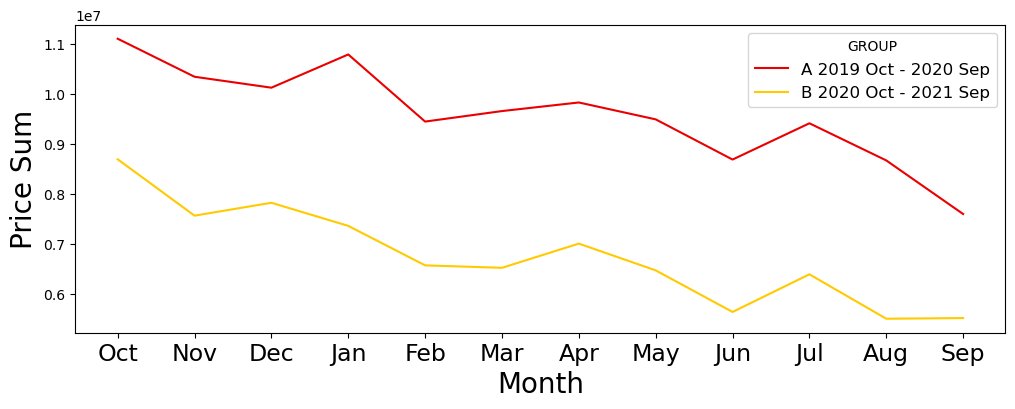

In [168]:
fig, axs = plt.subplots(figsize=(12, 4))
sns.lineplot(data=data, x='index', y='price', hue='group',markers= ["o","<"],palette = 'hot')
axs.set_xticks(range(1,13))
axs.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'],fontsize = 17)
axs.set_xlabel("Month", fontsize = 20)
axs.set_ylabel("Price Sum", fontsize = 20)
plt.legend(title='GROUP', loc='upper right', labels=['A 2019 Oct - 2020 Sep', 'B 2020 Oct - 2021 Sep'],fontsize = 12)
plt.show()

In [169]:
hotels["datetime"] = pd.to_datetime(hotels["date"])
hotels['monthYear'] = pd.to_datetime(hotels['datetime']).dt.to_period('M')
hotels['year'] = pd.to_datetime(hotels['datetime']).dt.year
hotels['month'] = pd.to_datetime(hotels['datetime']).dt.month

In [170]:
hotels.columns

Index(['travelCode', 'userCode', 'name', 'place', 'days', 'price', 'total',
       'date', 'datetime', 'monthYear', 'year', 'month'],
      dtype='object')

In [171]:
hotels.head()


,travelCode,userCode,name,place,days,price,total,date,datetime,monthYear,year,month
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019,2019-09-26,2019-09,2019,9
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019,2019-10-10,2019-10,2019,10
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019,2019-11-14,2019-11,2019,11
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019,2019-12-12,2019-12,2019,12
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019,2019-12-26,2019-12,2019,12


In [172]:
hotels.isnull().sum()


travelCode    0
userCode      0
name          0
place         0
days          0
price         0
total         0
date          0
datetime      0
monthYear     0
year          0
month         0
dtype: int64

In [173]:
flights.groupby("to").size()


to
Aracaju (SE)           37224
Brasilia (DF)          30779
Campo Grande (MS)      34748
Florianopolis (SC)     57317
Natal (RN)             23796
Recife (PE)            30480
Rio de Janeiro (RJ)    16815
Salvador (BH)          17104
Sao Paulo (SP)         23625
dtype: int64

In [174]:
hotels.groupby(['name', 'place']).size()


name      place              
Hotel A   Florianopolis (SC)     3330
Hotel AF  Sao Paulo (SP)         4828
Hotel AU  Recife (PE)            4467
Hotel BD  Natal (RN)             4829
Hotel BP  Brasilia (DF)          4437
Hotel BW  Campo Grande (MS)      4333
Hotel CB  Rio de Janeiro (RJ)    5029
Hotel K   Salvador (BH)          5094
Hotel Z   Aracaju (SE)           4205
dtype: int64

In [175]:
# Frame the dataset
flights = flights.loc[(flights['monthYear'] >= '2019-10') & (flights['monthYear'] <= '2021-09')]
hotels = hotels.loc[(hotels['monthYear'] >= '2019-10') & (hotels['monthYear'] <= '2021-09')]

In [176]:
flights_groupby = flights.groupby('monthYear')["price"].sum().to_frame()
hotels_groupby = hotels.groupby('monthYear')["price"].sum().to_frame()
flights_hotels = pd.merge(flights_groupby, hotels_groupby, on=['monthYear'], how='left')
flights_hotels = flights_hotels.rename(columns={'price_x': 'flightPrice', 'price_y': 'hotelPrice'})

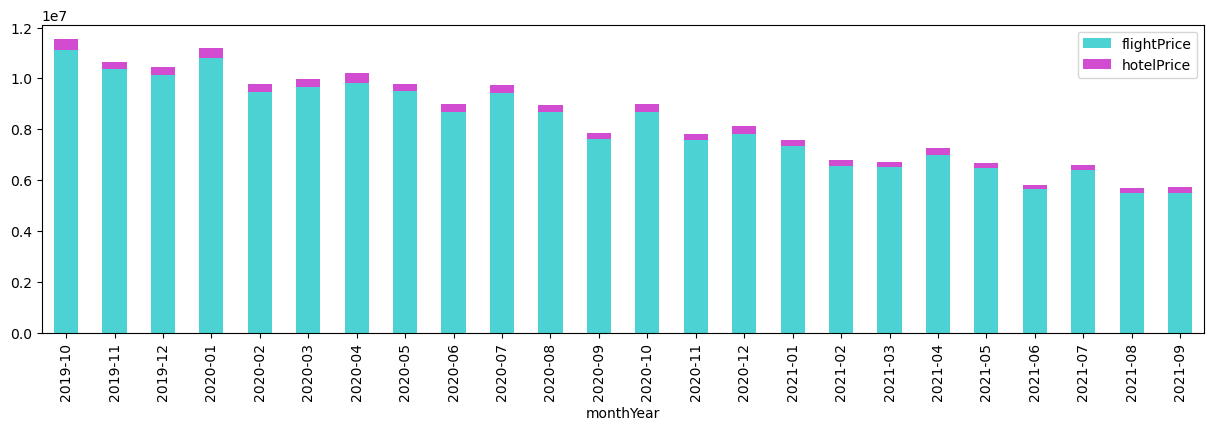

In [177]:
ax = flights_hotels.plot.bar(stacked=True,figsize=(15, 4),color=['c','m'],alpha=0.7)


/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/2003310434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(a,fontsize = 10, rotation = 45 )


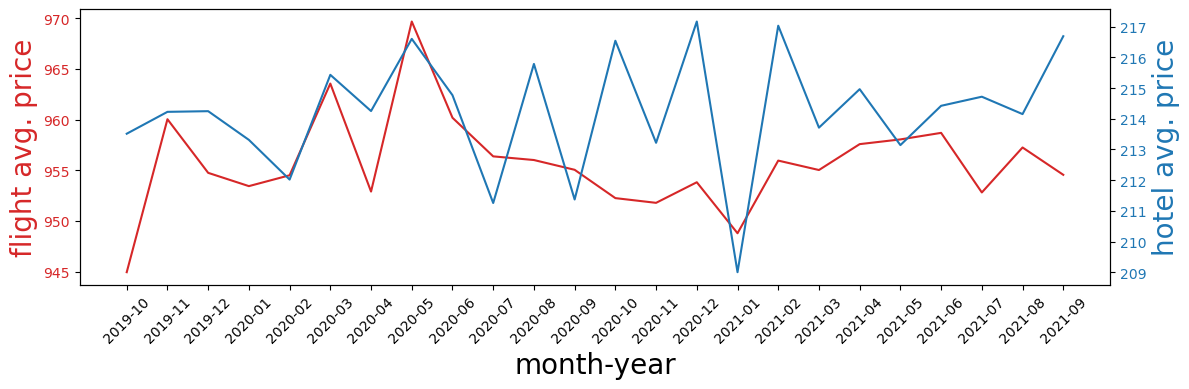

In [178]:
a = hotels["monthYear"].astype(str).to_numpy()
a = np.unique(a)
t = a

data1 = flights.groupby(flights["datetime"].dt.to_period('M'))["price"].mean().to_numpy()
data2 = hotels.groupby(hotels["datetime"].dt.to_period('M'))["price"].mean().to_numpy()

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('month-year', fontsize = 20)
ax1.set_xticklabels(a,fontsize = 10, rotation = 45 )


color = 'tab:red'
ax1.set_ylabel('flight avg. price', color=color, fontsize = 20)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('hotel avg. price', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/4068761382.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(a,fontsize = 10, rotation = 45 )


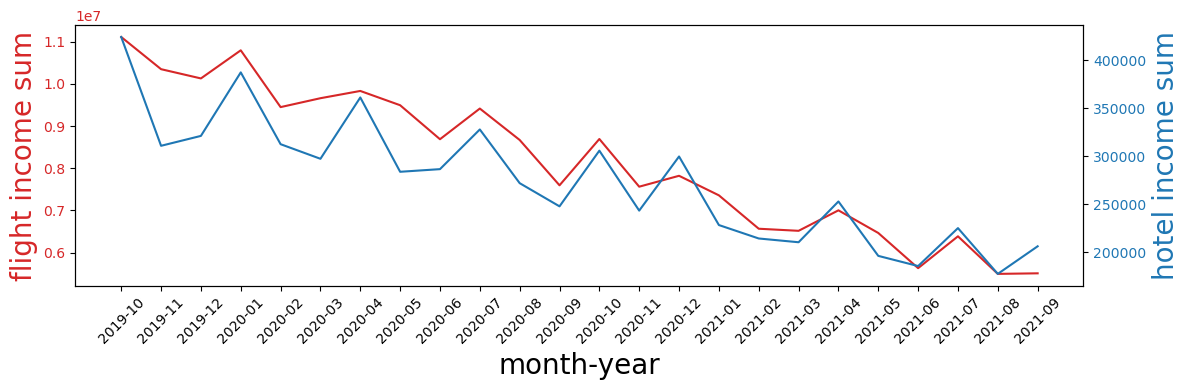

In [179]:
a = hotels["monthYear"].astype(str).to_numpy()
a = np.unique(a)
t = a

data1 = flights.groupby(flights["datetime"].dt.to_period('M'))["price"].sum().to_numpy()
data2 = hotels.groupby(hotels["datetime"].dt.to_period('M'))["price"].sum().to_numpy()

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('month-year', fontsize = 20)
ax1.set_xticklabels(a,fontsize = 10, rotation = 45 )


color = 'tab:red'
ax1.set_ylabel('flight income sum', color=color, fontsize = 20)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('hotel income sum', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [180]:
flight_combine = flights
# Take return ticket's price and date 
flight_combine['price_return'] = (flight_combine.groupby(['travelCode','userCode'])['price'].shift(-1))
flight_combine['date_return'] = (flight_combine.groupby(['travelCode','userCode'])['date'].shift(-1))
flight_combine["datetime_return"] = pd.to_datetime(flight_combine["date_return"])
# Drop one of the combined columns
flight_combine = flight_combine.dropna(how='any',axis=0)
# Calculate travel date
flight_combine['travel_date'] = flight_combine.datetime_return - flight_combine.datetime
# Extract integer from travel date
flight_combine['travel_date_int'] = flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/846698606.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_combine['travel_date'] = flight_combine.datetime_return - flight_combine.datetime
/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/846698606.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_combine['travel_date_int'] = flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)


In [181]:
flight_combine.columns

Index(['travelCode', 'userCode', 'from', 'to', 'flightType', 'price', 'time',
       'distance', 'agency', 'date', 'datetime', 'monthYear', 'year', 'month',
       'price_return', 'date_return', 'datetime_return', 'travel_date',
       'travel_date_int'],
      dtype='object')

In [182]:
flight_combine.head()


,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,datetime,monthYear,year,month,price_return,date_return,datetime_return,travel_date,travel_date_int
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019,2019-10-03,2019-10,2019,10,1127.36,10/04/2019,2019-10-04,1 days,1
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019,2019-10-10,2019-10,2019,10,1531.92,10/12/2019,2019-10-12,2 days,2
6,3,0,Aracaju (SE),Campo Grande (MS),economic,743.54,1.69,650.10,Rainbow,10/17/2019,2019-10-17,2019-10,2019,10,877.56,10/20/2019,2019-10-20,3 days,3
8,4,0,Recife (PE),Florianopolis (SC),economic,803.39,1.76,676.53,Rainbow,10/24/2019,2019-10-24,2019-10,2019,10,695.30,10/26/2019,2019-10-26,2 days,2
10,5,0,Brasilia (DF),Aracaju (SE),firstClass,1287.52,1.11,425.98,FlyingDrops,10/31/2019,2019-10-31,2019-10,2019,10,898.04,11/01/2019,2019-11-01,1 days,1


In [183]:
# Join round trip information with hotel information
# Take the needed information from hotel dataframe and create new dataframe
# Rename the columns in case misunderstanding
hotel_join = hotels.rename(columns={'name': 'name_hotel', 'days': 'days_hotel', 'total': 'total_hotel'})
hotel_join = hotel_join[['travelCode', 'userCode','name_hotel','days_hotel','total_hotel']]
# Left join the round flight and hotel
flight_hotel = pd.merge(flight_combine, hotel_join, on=['travelCode', 'userCode'], how='left')
# Create bundle column to distinguish the traveller who booked flight and hotel together
flight_hotel['combo'] = 0
flight_hotel['combo'] [flight_hotel['total_hotel']>0] = 1

/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/2097183213.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_hotel['combo'] [flight_hotel['total_hotel']>0] = 1


In [184]:
flight_hotel.columns

Index(['travelCode', 'userCode', 'from', 'to', 'flightType', 'price', 'time',
       'distance', 'agency', 'date', 'datetime', 'monthYear', 'year', 'month',
       'price_return', 'date_return', 'datetime_return', 'travel_date',
       'travel_date_int', 'name_hotel', 'days_hotel', 'total_hotel', 'combo'],
      dtype='object')

In [185]:
flight_hotel.head()


,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,...,month,price_return,date_return,datetime_return,travel_date,travel_date_int,name_hotel,days_hotel,total_hotel,combo
0,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019,...,10,1127.36,10/04/2019,2019-10-04,1 days,1,NaN,NaN,NaN,0
1,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019,...,10,1531.92,10/12/2019,2019-10-12,2 days,2,Hotel K,2.0,526.82,1
2,3,0,Aracaju (SE),Campo Grande (MS),economic,743.54,1.69,650.10,Rainbow,10/17/2019,...,10,877.56,10/20/2019,2019-10-20,3 days,3,NaN,NaN,NaN,0
3,4,0,Recife (PE),Florianopolis (SC),economic,803.39,1.76,676.53,Rainbow,10/24/2019,...,10,695.30,10/26/2019,2019-10-26,2 days,2,NaN,NaN,NaN,0
4,5,0,Brasilia (DF),Aracaju (SE),firstClass,1287.52,1.11,425.98,FlyingDrops,10/31/2019,...,10,898.04,11/01/2019,2019-11-01,1 days,1,NaN,NaN,NaN,0


In [186]:
flight_hotel.columns

Index(['travelCode', 'userCode', 'from', 'to', 'flightType', 'price', 'time',
       'distance', 'agency', 'date', 'datetime', 'monthYear', 'year', 'month',
       'price_return', 'date_return', 'datetime_return', 'travel_date',
       'travel_date_int', 'name_hotel', 'days_hotel', 'total_hotel', 'combo'],
      dtype='object')

In [187]:
flight_hotel.groupby(['combo']).size()


combo
0    71797
1    30550
dtype: int64

<AxesSubplot:title={'center':'How often did the users book a combo trip?'}, xlabel='count of combo', ylabel='count of user'>

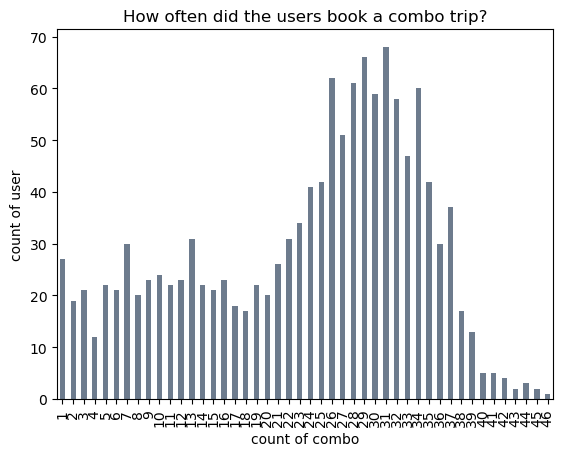

In [188]:
combo_count = flight_hotel.groupby(['combo','userCode']).size()
combo_count = combo_count.to_frame('count')
combo_count = combo_count.loc[1]
combo_count = combo_count.groupby('count').size()
combo_count = combo_count.to_frame('combo count')
combo_count.plot.bar(legend=None, color = '#6D7B8D', title = 'How often did the users book a combo trip?'
                        , xlabel = 'count of combo', ylabel = 'count of user')

<AxesSubplot:>

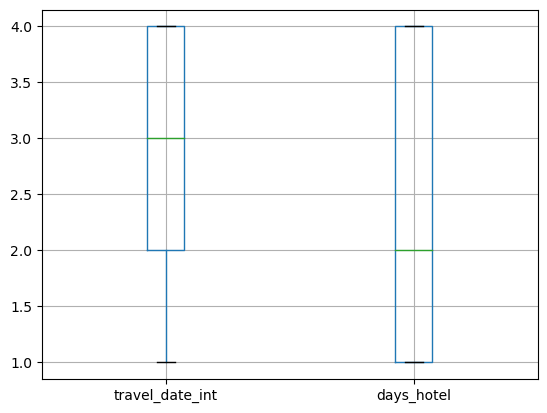

In [189]:
flight_hotel.boxplot(column=['travel_date_int','days_hotel'])


In [190]:
flight_hotel.groupby(['days_hotel']).size()


days_hotel
1.0    7649
2.0    7659
3.0    7603
4.0    7639
dtype: int64

In [191]:
churned = flight_hotel

In [192]:
# If it is the agency's first year order (since 2019/10~2020/09) then label it as old order.
conditions = [(churned['datetime'] >= '10/01/2019') &  (churned['datetime'] <= '09/30/2020')]
churned['orderOld'] = np.select(conditions, '1', default='0')
# If it is the agency's second year order (since 2020/10~2021/09) then label it as new order.
conditions = [(churned['datetime'] >= '10/01/2020') &  (churned['datetime'] <= '09/30/2021')]
churned['orderNew'] = np.select(conditions, '1', default='0')
# Str to Int
churned['orderNew']=churned['orderNew'].astype(int)
churned['orderOld']=churned['orderOld'].astype(int)

In [193]:
# Group by the users to calculate how many old orders and new orders if person has each.
churned_groupby = churned.groupby(['userCode']).sum()
# Reset the index
churned_groupby = churned_groupby.reset_index()
# Add a new column to calculate the old and new orders in total.
churned_groupby['orderSum'] = churned_groupby['orderNew'] + churned_groupby['orderOld']

In [194]:
# Categorized customer status into "new","retained", "churned"
churned_groupby['userStatus'] = 0
churned_groupby['userStatus'] [(churned_groupby['orderOld'] > 0)&(churned_groupby['orderNew'] > 0) ] = 'retained'
churned_groupby['userStatus'] [(churned_groupby['orderOld'] == 0)&(churned_groupby['orderNew'] > 0) ] = 'new'
churned_groupby['userStatus'] [(churned_groupby['orderOld'] > 0)&(churned_groupby['orderNew'] == 0) ] = 'churned'

/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/3020758555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned_groupby['userStatus'] [(churned_groupby['orderOld'] > 0)&(churned_groupby['orderNew'] > 0) ] = 'retained'


In [195]:
churned_groupby.groupby( ['userStatus'] ).size()


userStatus
churned     353
retained    971
dtype: int64

In [196]:
# Reset the timeframe
# Take the first year data (2019/10-2020/09)
flights = flights.loc[(flights['monthYear'] >= '2019-10') & (flights['monthYear'] <= '2020-09')]
hotels = hotels.loc[(hotels['monthYear'] >= '2019-10') & (hotels['monthYear'] <= '2020-09')]

In [197]:
# Redo the step in "Transform from Order Dimension to Customer Dimension" section because we need to re-calculate the record purely in the first year.
#Step 1 - Combine the round tickets into one.  
flight_combine = flights
# Take return ticket's price and date 
flight_combine['price_return'] = (flight_combine.groupby(['travelCode','userCode'])['price'].shift(-1))
flight_combine['date_return'] = (flight_combine.groupby(['travelCode','userCode'])['date'].shift(-1))
flight_combine["datetime_return"] = pd.to_datetime(flight_combine["date_return"])
# Drop one of the combined columns
flight_combine = flight_combine.dropna(how='any',axis=0)
# Calculate travel date
flight_combine['travel_date'] = flight_combine.datetime_return - flight_combine.datetime
# Extract integer from travel date
flight_combine['travel_date_int'] = flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
# Create pseudo column to count 
flight_combine['ticketCount'] = 1


/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/1811113033.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_combine['travel_date'] = flight_combine.datetime_return - flight_combine.datetime
/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/1811113033.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_combine['travel_date_int'] = flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
/var/folders/4m/

In [198]:
# Join round trip information with hotel information
# Take the needed information from hotel dataframe and create new dataframe
# Rename the columns in case misunderstanding
hotel_join = hotels.rename(columns={'name': 'name_hotel', 'days': 'days_hotel', 'total': 'total_hotel'})
hotel_join = hotel_join[['travelCode', 'userCode','name_hotel','days_hotel','total_hotel']]
# Left join the round flight and hotel
flight_hotel = pd.merge(flight_combine, hotel_join, on=['travelCode', 'userCode'], how='left')
# Create bundle column to distinguish the travller who booked flight and hotel together
flight_hotel['combo'] = 0
flight_hotel['combo'] [flight_hotel['total_hotel']>0] = 1

/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/2527097630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_hotel['combo'] [flight_hotel['total_hotel']>0] = 1


In [199]:
flight_hotel.groupby('userCode').sum().reset_index()

,userCode,travelCode,price,time,distance,year,month,price_return,travel_date_int,ticketCount,days_hotel,total_hotel,combo
0,0,1378,51614.00,72.86,28026.44,105027,334,48116.08,129,52,39.0,9076.28,16
1,1,460,3875.04,6.49,2496.15,10095,50,4183.69,5,5,2.0,386.72,2
2,2,6318,47779.93,70.81,27242.91,105027,334,45896.92,141,52,42.0,8052.44,15
3,3,13130,48418.45,67.25,25872.46,105027,334,47954.19,115,52,33.0,8082.12,15
4,4,23478,51739.36,72.17,27764.89,105027,334,48018.74,127,52,30.0,6282.96,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1335,7055750,44052.28,87.41,33655.36,105027,334,60365.39,130,52,35.0,6375.98,16
1320,1336,407583,2326.35,4.53,1741.42,6057,30,3210.53,9,3,2.0,495.24,1
1321,1337,3940462,26603.98,49.95,19227.59,58567,179,33003.43,73,29,31.0,7303.90,11
1322,1338,815379,5356.01,10.77,4139.76,12114,61,6700.53,19,6,4.0,990.48,1


In [200]:
# Integrate the user record from the customer dimension, rather than order dimension
user_record = flight_hotel.groupby('userCode').sum().reset_index()
# Take useful record from df_flight_hotel's numerical data
user_record = user_record[['userCode','ticketCount','price','price_return','distance','travel_date_int','days_hotel','total_hotel','combo']]
# User list with userStatus (churned or continued) from the previous section "Transform from Order Dimension to Customer Dimension
churned_list = churned_groupby[['userCode','userStatus']]
# Join the above two dataframes
customer = pd.merge(user_record,churned_list,on=['userCode'],how='left')
# Rename the columns in df_user in case misunderstanding
user_join = users.rename(columns={'code': 'userCode', 'company': 'userCompany', 'name': 'userName'})
# Join the above two dataframes
customer = pd.merge(customer,user_join,on=['userCode'],how='left')

In [201]:
# Create new columns for analysis
customer['flightPriceDiffer'] = customer['price_return'] - customer['price']
customer['flightPriceSum'] = customer['price_return'] + customer['price']
customer['flightPriceDistanceAvg'] = customer['flightPriceSum']/customer['distance']
customer['hotelPriceDayAvg'] = customer['total_hotel']/customer['days_hotel']
customer['flightPriceDifferDistanceAvg'] = customer['flightPriceDiffer']/customer['distance']
customer['flightPriceDifferTicketAvg'] = customer['flightPriceDiffer']/customer['ticketCount']
customer['flightPriceTicketAvg'] = customer['flightPriceSum']/customer['ticketCount']
customer['comboFrequency'] = customer['combo']/customer['ticketCount']
customer['hotelStayDayAvg'] = customer['days_hotel']/customer['combo']

# Unify the form of name
customer = customer.rename(columns={'price': 'flightPriceGo', 
                                       'price_return': 'flightPriceReturn',
                                       'distance': 'flightDistance',
                                       'travel_date_int':'travelDays',
                                       'days_hotel':'hotelDays',
                                        'total_hotel':'hotelPrice'
                                      })

In [202]:
customer['userStatus01'] = 0
customer['userStatus01'] [customer['userStatus'] == 'churned'] = 1
customer['hotelPriceDayAvg'] = customer['hotelPriceDayAvg'].fillna(0)
customer['hotelStayDayAvg'] = customer['hotelStayDayAvg'].fillna(0)

/var/folders/4m/yt8hbrd947q4lr3s_f31chk00000gn/T/ipykernel_78819/1064853918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['userStatus01'] [customer['userStatus'] == 'churned'] = 1


In [203]:
customer.isnull().sum()

userCode                        0
ticketCount                     0
flightPriceGo                   0
flightPriceReturn               0
flightDistance                  0
travelDays                      0
hotelDays                       0
hotelPrice                      0
combo                           0
userStatus                      0
userCompany                     0
userName                        0
gender                          0
age                             0
ageRange                        0
flightPriceDiffer               0
flightPriceSum                  0
flightPriceDistanceAvg          0
hotelPriceDayAvg                0
flightPriceDifferDistanceAvg    0
flightPriceDifferTicketAvg      0
flightPriceTicketAvg            0
comboFrequency                  0
hotelStayDayAvg                 0
userStatus01                    0
dtype: int64

In [204]:
customer['ageRange'] = pd.cut(customer.age, [20,30,40,50,60,70])
#customer.groupby("ageRange").size()
customer['hotelPriceDayAvgRange'] = pd.cut(customer.hotelPriceDayAvg, [0,50, 100,150,200,250,300,350,400])
#customer.groupby("hotelPriceDayAvgRange").size()
customer['flightPriceDifferTicketAvgRange'] = pd.cut(customer.flightPriceDifferTicketAvg, 
                                                        [-400,-300, -200,-100, 0, 100,200,300,400])
#customer.groupby("flightPriceDifferTicketAvgRange").size()
customer['travelDaysRange'] = pd.cut(customer.travelDays, 
                                                        [0,25,50,75,100,125,150,175,200])
#customer.groupby("travelDaysRange").size()

<AxesSubplot:xlabel='hotelPriceDayAvgRange', ylabel='count'>

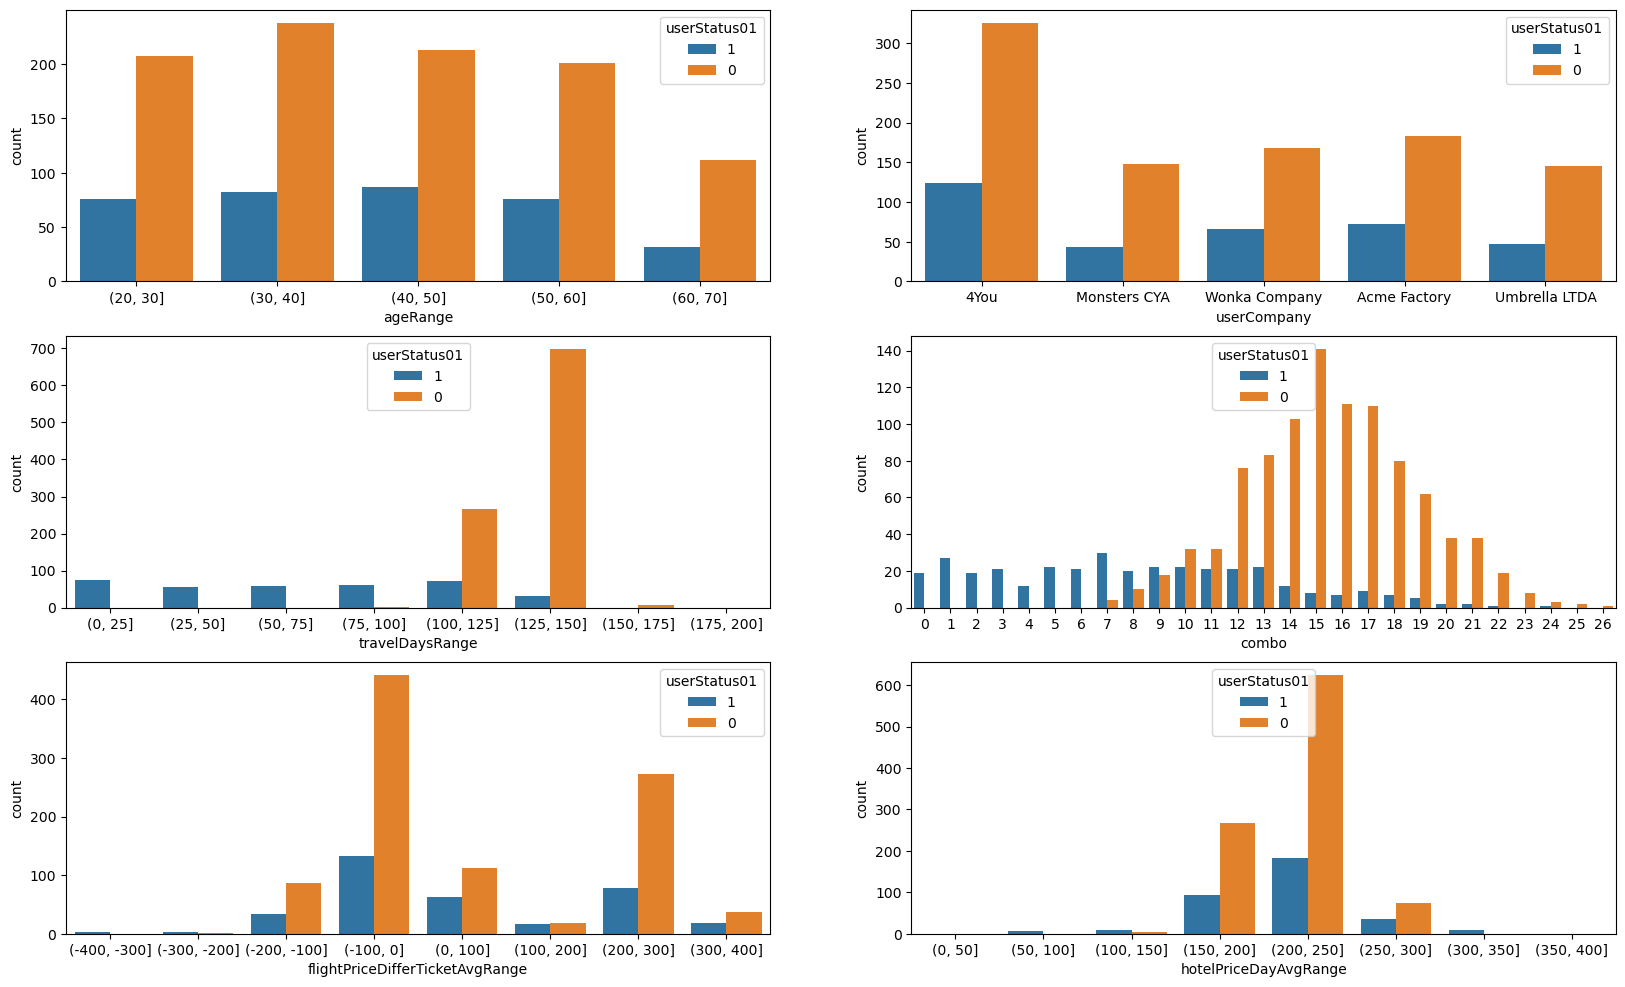

In [205]:
fig, axarr = plt.subplots(3,2, figsize=(20,12))
sns.countplot(x='ageRange', hue = "userStatus01", data = customer, 
              hue_order = [1,0], ax=axarr[0][0] )
sns.countplot(x='userCompany', hue = "userStatus01", data = customer,
              hue_order = [1,0], ax=axarr[0][1] )
sns.countplot(x='combo', hue = "userStatus01", data = customer,
              hue_order = [1,0], ax=axarr[1][1] )
sns.countplot(x='travelDaysRange', hue = "userStatus01", data = customer,
              hue_order = [1,0], ax=axarr[1][0] )
sns.countplot(x='flightPriceDifferTicketAvgRange', hue = "userStatus01", data = customer, 
              hue_order = [1,0], ax=axarr[2][0] )
sns.countplot(x='hotelPriceDayAvgRange', hue = "userStatus01", data = customer,
              hue_order = [1,0], ax=axarr[2][1] )

In [207]:
customer.to_csv('./data/BusinessTravelChurn.csv')

In [215]:
customer.groupby('userStatus').size()


userStatus
churned     353
retained    971
dtype: int64

In [216]:
predictors = ['ticketCount',
'flightPriceGo',
'flightPriceReturn',
'flightDistance',
'travelDays',
'hotelDays',
'hotelPrice',
'combo',
'age',
'flightPriceSum',
'flightPriceDistanceAvg',
'hotelPriceDayAvg',
'flightPriceDiffer',
'flightPriceDifferDistanceAvg',
'flightPriceDifferTicketAvg',
'flightPriceTicketAvg',
'comboFrequency',
'hotelStayDayAvg',
'userCompany'
# 'userStatus',
# 'userName',
# 'gender',
# 'ageRange',
]
outcome = 'userStatus01'
X = pd.get_dummies(customer[predictors], prefix='', prefix_sep='')
y = customer[outcome]


In [217]:
rus = RandomUnderSampler(random_state=777)
X_res, y_res = rus.fit_resample(X,y)
print('Resampled dataset shape %s' % Counter(y_res))


NameError: name 'RandomUnderSampler' is not defined